Insights:
1. Clustering Methodology:
   - Multi-dimensional feature analysis
   - KMeans clustering with 5 segments
   - Comprehensive metrics evaluation

2. Segmentation Metrics:
   - Davies-Bouldin Index used for evaluation
   - Silhouette score assesses cluster separation
   - Calinski-Harabasz score measures cluster distinctiveness

3. Strategic Implications:
   - Identifies distinct customer groups
   - Enables targeted marketing strategies
   - Supports personalized customer approach

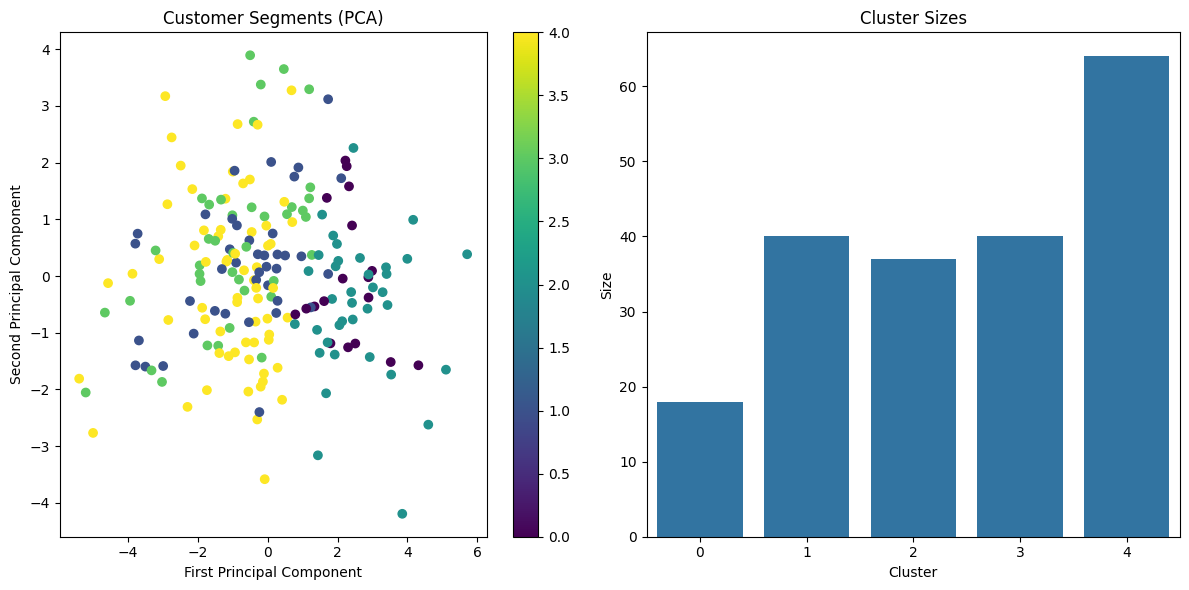

Number of clusters: 5
Davies-Bouldin Index: 2.163
Silhouette Score: 0.144
Calinski-Harabasz Score: 24.685


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

customers = pd.read_csv('/content/Customers.csv')
products = pd.read_csv('/content/Products.csv')
transactions = pd.read_csv('/content/Transactions.csv')

def create_customer_features(customers, transactions, products):
    # Merge data
    tx_products = transactions.merge(products, on='ProductID')

    # Customer metrics
    customer_metrics = tx_products.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean'],
        'Price_y': 'mean'
    }).fillna(0)
    customer_metrics.columns = ['tx_count', 'total_spend', 'avg_spend',
                              'spend_std', 'total_items', 'avg_items', 'avg_price']

    # Category preferences
    category_pivot = pd.pivot_table(
        tx_products,
        values='Quantity',
        index='CustomerID',
        columns='Category',
        aggfunc='sum',
        fill_value=0
    )

    # Region encoding
    region_dummies = pd.get_dummies(customers['Region'], prefix='region')
    region_dummies.index = customers['CustomerID']

    # Combine features
    features = customer_metrics.join(category_pivot).join(region_dummies)

    return features

def davies_bouldin_index(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Calculate cluster dispersions
    dispersions = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            dispersions[i] = np.mean(np.linalg.norm(cluster_points - cluster_centers[i], axis=1))

    # Calculate Davies-Bouldin Index
    db_index = 0
    for i in range(n_clusters):
        max_ratio = 0
        for j in range(n_clusters):
            if i != j:
                ratio = ((dispersions[i] + dispersions[j]) /
                        np.linalg.norm(cluster_centers[i] - cluster_centers[j]))
                max_ratio = max(max_ratio, ratio)
        db_index += max_ratio

    return db_index / n_clusters

def perform_clustering(features, n_clusters=5):
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Calculate metrics
    silhouette = silhouette_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    db_index = davies_bouldin_index(X_scaled, labels)

    # Dimensionality reduction for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Visualization
    plt.figure(figsize=(12, 6))

    # Cluster scatter plot
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title('Customer Segments (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)

    # Cluster characteristics
    plt.subplot(1, 2, 2)
    cluster_stats = pd.DataFrame({
        'Cluster': range(n_clusters),
        'Size': np.bincount(labels),
        'Avg_Spend': [features['total_spend'][labels == i].mean() for i in range(n_clusters)]
    })
    sns.barplot(data=cluster_stats, x='Cluster', y='Size')
    plt.title('Cluster Sizes')
    plt.tight_layout()
    plt.show()

    return {
        'labels': labels,
        'silhouette': silhouette,
        'calinski': calinski,
        'db_index': db_index,
        'cluster_stats': cluster_stats
    }

# Execute clustering
features = create_customer_features(customers, transactions, products)
results = perform_clustering(features)

# Print results
print(f"Number of clusters: 5")
print(f"Davies-Bouldin Index: {results['db_index']:.3f}")
print(f"Silhouette Score: {results['silhouette']:.3f}")
print(f"Calinski-Harabasz Score: {results['calinski']:.3f}")

# Save cluster assignments
cluster_assignments = pd.DataFrame({
    'CustomerID': features.index,
    'Cluster': results['labels']
})
cluster_assignments.to_csv('cluster_assignments.csv', index=False)